In [1]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.panda2 as panda2

import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan


# run "ping" command
!ping -c 1 192.168.10.16

# instancíate a Panda2 class
dut = panda2.Panda2()
# read yaml file and connect to FPGA
dut.init()
dut.set_sync(auto_sync=True)  ## do not delete this


PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.098 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.098/0.098/0.098/0.000 ms


2024-08-14 13:35:38,188 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-08-14 13:35:38,190 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module panda2.pulse_gen_div, base_addr 0x100
2024-08-14 13:35:38,192 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-08-14 13:35:38,193 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-08-14 13:35:38,198 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 1), module panda2.timestamp_div, base_addr 0x1c0
2024-08-14 13:35:38,201 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x200
20

In [2]:
# define col, row
col, row = 10, 0
### configure chip and enable injection
dut.set_en_inj([col, row])

# this is for Injection card
#dut.set_inj_amp(1.0)

# set ampout ON
dut.set_en_ampout([col])


### inj_n: number of pulses to be injected. 0=continuous injection
# 1 = 1 clock of 40MHz = 25ns
dut.set_inj(inj_n=100, inj_width=1024*8, inj_delay=1024*8, ext=True)
dut.inject()

dut.set_tdac(0, comp='both')
tdac0 = np.copy(dut.PixelConf['tdac0'])

# sets VDAC and DAC
dut.set_conf(VDACTh=110, VDACTh2=110, VDACBL=102, VN=30, INFoll2=20, hidrEnB=0)  ## set lowest (largest in number) threshold

# sets comparator
en_comp = np.copy(dut.PixelConf['en_comp0'])
en_comp[:,:] = 0
en_comp[col, row] = 1
dut.set_en_comp(en_comp, comp='both')
dut.set_en_hitbus([col])

# set_sync: set SyncRes
dut.set_sync(auto_sync=True)

# set timestamp module ON
dut.set_ts_inj(True)

# set the data reciever ON
dut.set_rx(True)
# but mask data for this moment
dut.mask_rx(True)



2024-08-14 13:35:38,392 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00000400 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_10000
2024-08-14 13:35:38,400 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00000400
2024-08-14 13:35:38,428 - root - [INFO    ] (MainThread) _write_conf row0 en_comp0[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac0[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-08-14 13:35:38,441 - root - [INFO    ] (MainThread) _write_conf row1 en_comp0[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac0[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-08-14 13:35:38,451 - root - [INFO    ] (MainThread) _write_conf row2 en_comp0[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac0[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [3]:
import lab_devices.lab_devices as lab_devices  ## import the library for Pulse genetor
#importlib.reload(lab_devices)                  ## reloading

# instanciate a pulse gen. class and connect to the PulseGen.
plsgen = lab_devices.PlsGen()
plsgen.init()

In [4]:
### only one selected pixel
factor=1
plsgen.set_inj_amp(0.02*factor, 'V')  # set amp to 200mV
scan = injection_scan.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.05, 0.5, 0.05)*factor,
                  cols=None,
                  rows=None,
                  #plsgen=plsgen
                  )
fhit = scan.analyze()

2024-08-14 13:36:34,424 - root - [WARNING ] (MainThread) set_inj_amp: high cannot be 0.020V. it will be forced to 0.1+0.000V
2024-08-14 13:36:34,431 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.100
2024-08-14 13:36:34,583 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-08-14 13:36:34,584 - root - [INFO    ] (MainThread) Scan start time: 2024-08-14_13:36:34
2024-08-14 13:36:34,738 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-08-14 13:36:34,875 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-08-14 13:36:35,010 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-08-14 13:36:35,113 - root - [INFO    ] (MainThread) Received words: 0
2024-08-14 13:36:35,115 - root - [INFO    ] (MainThread) Data queue size: 0
2024-08-14 13:36:35,116 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-08-14 13:36:35,117 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-08-14 13:

3.28s 9858/9858 hit=1437 ts=900


2024-08-14 13:36:40,347 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-08-14 13:36:40,349 - root - [INFO    ] (MainThread) 0.39s hit=1437/1437 event=1430 ts=900/900
2024-08-14 13:36:40,351 - root - [INFO    ] (MainThread) alingned to timestamp /home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/output/injection_scan/20240814_133634_injection_hit.h5


In [16]:
## do scurve of multiple pixels
#for col in [0]:   ### col =0, row =0
 #  for row in [0]:

#for col in [10]:  ## all pixel in col=10
#    for row in [1]:
#    for row in range(dut.nrows):
for col in [10]:  ## 4 pixels
   for row in [1,2,3,4,5,56,57,58,59,60]:


#for col in range(dut.ncols):  ## full matrix
#    for row in range(dut.nrows):
        dut.mask_rx(True)
        dut.set_en_inj([col, row])
        dut.set_en_ampout([col])
        en_comp = np.copy(dut.PixelConf['en_comp0'])
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='both')
        dut.set_en_hitbus([col])

        dut.set_inj_amp(0.02, 'V')
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 1.05, 0.005)*10, cols=None, rows=None, plsgen=plsgen)
        fhit = scan.analyze()

2023-12-01 19:50:07,440 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00000400 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00100
2023-12-01 19:50:07,444 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00000400
2023-12-01 19:50:07,448 - root - [INFO    ] (MainThread) set_en_hitbus: en_hitbus_col=0x1ffffbff
2023-12-01 19:50:07,449 - root - [INFO    ] (MainThread) inj_amp: 49
2023-12-01 19:50:07,449 - root - [INFO    ] (MainThread) Initializing InjectionScan
2023-12-01 19:50:07,449 - root - [INFO    ] (MainThread) Scan start time: 2023-12-01_19:50:07
2023-12-01 19:50:07,519 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2023-12-01 19:50:07,643 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 36
2023-12-01 19:50:08,079 - root - [INFO    ] (Ma

2023-12-01 19:50:20,469 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.050
2023-12-01 19:50:20,802 - root - [INFO    ] (MainThread) InjectionScan: step=37 ts=300 hit=1000
2023-12-01 19:50:20,808 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.100
2023-12-01 19:50:21,141 - root - [INFO    ] (MainThread) InjectionScan: step=38 ts=300 hit=1000
2023-12-01 19:50:21,147 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.150
2023-12-01 19:50:21,480 - root - [INFO    ] (MainThread) InjectionScan: step=39 ts=300 hit=1000
2023-12-01 19:50:21,485 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.200
2023-12-01 19:50:21,809 - root - [INFO    ] (MainThread) InjectionScan: step=40 ts=300 hit=1000
2023-12-01 19:50:21,815 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.250
2023-12-01 19:50:22,149 - root - [INFO    ] (MainThread) InjectionScan: step=41 ts=300 hit=1001
2023-12-01 19:50:22,154 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.300
2023-12-01 19:50

2023-12-01 19:50:35,912 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.350
2023-12-01 19:50:36,235 - root - [INFO    ] (MainThread) InjectionScan: step=83 ts=300 hit=1000
2023-12-01 19:50:36,240 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.400
2023-12-01 19:50:36,576 - root - [INFO    ] (MainThread) InjectionScan: step=84 ts=300 hit=1000
2023-12-01 19:50:36,581 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.450
2023-12-01 19:50:36,908 - root - [INFO    ] (MainThread) InjectionScan: step=85 ts=300 hit=1000
2023-12-01 19:50:36,916 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.500
2023-12-01 19:50:37,250 - root - [INFO    ] (MainThread) InjectionScan: step=86 ts=300 hit=1000
2023-12-01 19:50:37,255 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.550
2023-12-01 19:50:37,582 - root - [INFO    ] (MainThread) InjectionScan: step=87 ts=300 hit=1000
2023-12-01 19:50:37,589 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:50

2023-12-01 19:50:51,336 - root - [INFO    ] (MainThread) InjectionScan: step=128 ts=300 hit=1000
2023-12-01 19:50:51,341 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.650
2023-12-01 19:50:51,676 - root - [INFO    ] (MainThread) InjectionScan: step=129 ts=300 hit=1000
2023-12-01 19:50:51,683 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.700
2023-12-01 19:50:52,007 - root - [INFO    ] (MainThread) InjectionScan: step=130 ts=300 hit=1000
2023-12-01 19:50:52,013 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.750
2023-12-01 19:50:52,346 - root - [INFO    ] (MainThread) InjectionScan: step=131 ts=300 hit=1001
2023-12-01 19:50:52,352 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.800
2023-12-01 19:50:52,685 - root - [INFO    ] (MainThread) InjectionScan: step=132 ts=300 hit=1000
2023-12-01 19:50:52,690 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.850
2023-12-01 19:50:53,014 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=100

2023-12-01 19:51:06,441 - root - [INFO    ] (MainThread) afg3252 set_amp high=8.900
2023-12-01 19:51:06,774 - root - [INFO    ] (MainThread) InjectionScan: step=174 ts=300 hit=1000
2023-12-01 19:51:06,779 - root - [INFO    ] (MainThread) afg3252 set_amp high=8.950
2023-12-01 19:51:07,113 - root - [INFO    ] (MainThread) InjectionScan: step=175 ts=300 hit=1000
2023-12-01 19:51:07,119 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.000
2023-12-01 19:51:07,442 - root - [INFO    ] (MainThread) InjectionScan: step=176 ts=300 hit=1000
2023-12-01 19:51:07,447 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.050
2023-12-01 19:51:07,781 - root - [INFO    ] (MainThread) InjectionScan: step=177 ts=300 hit=1000
2023-12-01 19:51:07,788 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.100
2023-12-01 19:51:08,117 - root - [INFO    ] (MainThread) InjectionScan: step=178 ts=300 hit=1000
2023-12-01 19:51:08,124 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 

2023-12-01 19:51:22,826 - root - [INFO    ] (MainThread) _write_conf row2 en_comp2[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2023-12-01 19:51:22,829 - root - [INFO    ] (MainThread) set_en_hitbus: en_hitbus_col=0x1ffffbff
2023-12-01 19:51:22,830 - root - [INFO    ] (MainThread) inj_amp: 49
2023-12-01 19:51:22,830 - root - [INFO    ] (MainThread) Initializing InjectionScan
2023-12-01 19:51:22,830 - root - [INFO    ] (MainThread) Scan start time: 2023-12-01_19:51:22
2023-12-01 19:51:22,898 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


5.57s 259290/259290 hit=39532 ts=20600


2023-12-01 19:51:23,055 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 24
2023-12-01 19:51:23,487 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:51:23,489 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:51:23,491 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 19:51:23,493 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:51:23,494 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:51:23,496 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:51:23,499 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:51:23,506 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:51:23,798 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 19:51:23,803 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 19:51:24,136 - root - [INFO    ] (MainThread) InjectionScan: step=

2023-12-01 19:51:37,560 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.300
2023-12-01 19:51:37,886 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:51:37,893 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:51:38,226 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:51:38,231 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:51:38,562 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 19:51:38,568 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:51:38,894 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:51:38,901 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:51:39,236 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1000
2023-12-01 19:51:39,241 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 19:51

2023-12-01 19:51:52,996 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:51:53,319 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1001
2023-12-01 19:51:53,324 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:51:53,659 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1000
2023-12-01 19:51:53,665 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:51:53,997 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1000
2023-12-01 19:51:54,003 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:51:54,336 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1000
2023-12-01 19:51:54,343 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:51:54,668 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=1000
2023-12-01 19:51:54,676 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 19:51

2023-12-01 19:52:08,425 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=1010
2023-12-01 19:52:08,430 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:52:08,764 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=1005
2023-12-01 19:52:08,769 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:52:09,093 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=1015
2023-12-01 19:52:09,098 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:52:09,431 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=1015
2023-12-01 19:52:09,437 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 19:52:09,768 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=1015
2023-12-01 19:52:09,773 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 19:52:10,106 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=100

2023-12-01 19:52:23,530 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 19:52:23,857 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=1680
2023-12-01 19:52:23,864 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 19:52:24,193 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=1675
2023-12-01 19:52:24,200 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 19:52:24,530 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=1646
2023-12-01 19:52:24,538 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 19:52:24,861 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=1545
2023-12-01 19:52:24,866 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 19:52:25,199 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=1545
2023-12-01 19:52:25,206 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

6.35s 290699/290699 hit=45810 ts=20600


2023-12-01 19:52:39,228 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2023-12-01 19:52:39,663 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:52:39,664 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:52:39,664 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 19:52:39,665 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:52:39,665 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:52:39,665 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:52:39,666 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:52:39,672 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:52:39,974 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 19:52:39,979 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 19:52:40,311 - root - [INFO    ] (MainThread) InjectionScan: step=

2023-12-01 19:52:54,066 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:52:54,072 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:52:54,405 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:52:54,413 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:52:54,737 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 19:52:54,742 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:52:55,075 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:52:55,081 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:52:55,408 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1001
2023-12-01 19:52:55,415 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 19:52:55,749 - root - [INFO    ] (MainThread) InjectionScan: step=47 ts=300 hit=1000
2023

2023-12-01 19:53:09,173 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:53:09,506 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1001
2023-12-01 19:53:09,511 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:53:09,834 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1000
2023-12-01 19:53:09,839 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:53:10,173 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1000
2023-12-01 19:53:10,182 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:53:10,514 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1000
2023-12-01 19:53:10,519 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:53:10,841 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=1000
2023-12-01 19:53:10,846 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 19:53

2023-12-01 19:53:24,603 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=1000
2023-12-01 19:53:24,611 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:53:24,939 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=1000
2023-12-01 19:53:24,947 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:53:25,272 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=1000
2023-12-01 19:53:25,278 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:53:25,611 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=1000
2023-12-01 19:53:25,616 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 19:53:25,949 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=1010
2023-12-01 19:53:25,954 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 19:53:26,277 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=100

2023-12-01 19:53:39,708 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 19:53:40,041 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=1500
2023-12-01 19:53:40,048 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 19:53:40,372 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=1500
2023-12-01 19:53:40,378 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 19:53:40,711 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=1500
2023-12-01 19:53:40,716 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 19:53:41,041 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=1500
2023-12-01 19:53:41,046 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 19:53:41,379 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=1500
2023-12-01 19:53:41,384 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

6.48s 288512/288512 hit=45378 ts=20600


2023-12-01 19:53:55,526 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2023-12-01 19:53:55,967 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:53:55,968 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:53:55,968 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 19:53:55,968 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:53:55,968 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:53:55,969 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:53:55,970 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:53:55,976 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:53:56,278 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 19:53:56,284 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 19:53:56,609 - root - [INFO    ] (MainThread) InjectionScan: step=

2023-12-01 19:54:10,367 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:54:10,373 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:54:10,706 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:54:10,711 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:54:11,044 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 19:54:11,050 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:54:11,377 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:54:11,384 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:54:11,708 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1000
2023-12-01 19:54:11,713 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 19:54:12,047 - root - [INFO    ] (MainThread) InjectionScan: step=47 ts=300 hit=1000
2023

2023-12-01 19:54:25,478 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:54:25,801 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1120
2023-12-01 19:54:25,806 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:54:26,140 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1146
2023-12-01 19:54:26,145 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:54:26,478 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1120
2023-12-01 19:54:26,484 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:54:26,807 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1165
2023-12-01 19:54:26,812 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:54:27,145 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=1250
2023-12-01 19:54:27,151 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 19:54

2023-12-01 19:54:40,903 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=1500
2023-12-01 19:54:40,911 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:54:41,246 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=1500
2023-12-01 19:54:41,253 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:54:41,578 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=1500
2023-12-01 19:54:41,585 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:54:41,911 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=1500
2023-12-01 19:54:41,919 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 19:54:42,244 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=1500
2023-12-01 19:54:42,251 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 19:54:42,588 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=150

2023-12-01 19:54:56,012 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 19:54:56,344 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=2000
2023-12-01 19:54:56,350 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 19:54:56,672 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=2000
2023-12-01 19:54:56,677 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 19:54:57,010 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=2000
2023-12-01 19:54:57,015 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 19:54:57,349 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=2000
2023-12-01 19:54:57,355 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 19:54:57,687 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=2000
2023-12-01 19:54:57,694 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

7.65s 343574/343574 hit=56405 ts=20600


2023-12-01 19:55:13,031 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2023-12-01 19:55:13,478 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:55:13,479 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:55:13,479 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 19:55:13,479 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:55:13,480 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:55:13,480 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:55:13,482 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:55:13,487 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:55:13,790 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 19:55:13,795 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 19:55:14,128 - root - [INFO    ] (MainThread) InjectionScan: step=1

2023-12-01 19:55:27,879 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:55:27,884 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:55:28,218 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:55:28,223 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:55:28,556 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 19:55:28,561 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:55:28,884 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:55:28,890 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:55:29,226 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1000
2023-12-01 19:55:29,231 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 19:55:29,566 - root - [INFO    ] (MainThread) InjectionScan: step=47 ts=300 hit=1000
2023

2023-12-01 19:55:42,997 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:55:43,323 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1480
2023-12-01 19:55:43,331 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:55:43,655 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1555
2023-12-01 19:55:43,660 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:55:43,993 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1575
2023-12-01 19:55:43,999 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:55:44,322 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1590
2023-12-01 19:55:44,328 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:55:44,655 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=1615
2023-12-01 19:55:44,660 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 19:55

2023-12-01 19:55:58,410 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=2276
2023-12-01 19:55:58,415 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:55:58,748 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=2305
2023-12-01 19:55:58,756 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:55:59,094 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=2360
2023-12-01 19:55:59,101 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:55:59,419 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=2395
2023-12-01 19:55:59,424 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 19:55:59,757 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=2460
2023-12-01 19:55:59,762 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 19:56:00,097 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=246

2023-12-01 19:56:13,522 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 19:56:13,845 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=3000
2023-12-01 19:56:13,851 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 19:56:14,184 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=3000
2023-12-01 19:56:14,189 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 19:56:14,521 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=3000
2023-12-01 19:56:14,526 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 19:56:14,860 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=3000
2023-12-01 19:56:14,865 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 19:56:15,189 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=3000
2023-12-01 19:56:15,195 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

10.34s 441205/441205 hit=75918 ts=20600


2023-12-01 19:56:33,217 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 12
2023-12-01 19:56:33,649 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:56:33,650 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:56:33,651 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 19:56:33,652 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:56:33,653 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:56:33,654 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:56:33,656 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:56:33,662 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:56:33,956 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2023-12-01 19:56:33,961 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 19:56:34,293 - root - [INFO    ] (MainThread) InjectionScan: step=

2023-12-01 19:56:48,050 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:56:48,057 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:56:48,392 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:56:48,399 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:56:48,724 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 19:56:48,731 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:56:49,056 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:56:49,061 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:56:49,394 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1001
2023-12-01 19:56:49,400 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 19:56:49,733 - root - [INFO    ] (MainThread) InjectionScan: step=47 ts=300 hit=1000
2023

2023-12-01 19:57:03,154 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:57:03,486 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1436
2023-12-01 19:57:03,491 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:57:03,823 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1510
2023-12-01 19:57:03,828 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:57:04,150 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1541
2023-12-01 19:57:04,155 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:57:04,497 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1596
2023-12-01 19:57:04,502 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:57:04,834 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=1580
2023-12-01 19:57:04,840 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 19:57

2023-12-01 19:57:18,588 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=2150
2023-12-01 19:57:18,594 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:57:18,922 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=2145
2023-12-01 19:57:18,929 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:57:19,254 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=2220
2023-12-01 19:57:19,260 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:57:19,595 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=2271
2023-12-01 19:57:19,601 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 19:57:19,934 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=2315
2023-12-01 19:57:19,939 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 19:57:20,271 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=233

2023-12-01 19:57:33,690 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 19:57:34,024 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=3000
2023-12-01 19:57:34,029 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 19:57:34,354 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=3000
2023-12-01 19:57:34,359 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 19:57:34,685 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=3000
2023-12-01 19:57:34,690 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 19:57:35,023 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=3000
2023-12-01 19:57:35,029 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 19:57:35,365 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=3000
2023-12-01 19:57:35,370 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

10.25s 437177/437177 hit=75101 ts=20600


2023-12-01 19:57:53,282 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2023-12-01 19:57:53,716 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:57:53,716 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:57:53,717 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 19:57:53,717 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:57:53,718 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:57:53,718 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:57:53,721 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:57:53,727 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:57:54,029 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 19:57:54,034 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 19:57:54,366 - root - [INFO    ] (MainThread) InjectionScan: step=

2023-12-01 19:58:08,119 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:58:08,125 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:58:08,458 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:58:08,463 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:58:08,789 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 19:58:08,794 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:58:09,128 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:58:09,133 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:58:09,466 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1000
2023-12-01 19:58:09,471 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 19:58:09,795 - root - [INFO    ] (MainThread) InjectionScan: step=47 ts=300 hit=1000
2023

2023-12-01 19:58:23,227 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:58:23,560 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1480
2023-12-01 19:58:23,565 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:58:23,889 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1485
2023-12-01 19:58:23,895 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:58:24,218 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1535
2023-12-01 19:58:24,223 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:58:24,567 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1505
2023-12-01 19:58:24,572 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:58:24,896 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=1630
2023-12-01 19:58:24,901 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 19:58

2023-12-01 19:58:38,653 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=2155
2023-12-01 19:58:38,658 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:58:38,990 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=2180
2023-12-01 19:58:38,996 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:58:39,329 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=2190
2023-12-01 19:58:39,337 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:58:39,662 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=2305
2023-12-01 19:58:39,669 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 19:58:40,002 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=2300
2023-12-01 19:58:40,013 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 19:58:40,337 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=238

2023-12-01 19:58:53,755 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 19:58:54,084 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=3000
2023-12-01 19:58:54,090 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 19:58:54,421 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=3000
2023-12-01 19:58:54,430 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 19:58:54,756 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=3000
2023-12-01 19:58:54,763 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 19:58:55,088 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=3000
2023-12-01 19:58:55,095 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 19:58:55,429 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=3000
2023-12-01 19:58:55,434 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

10.49s 437864/437864 hit=75241 ts=20600


2023-12-01 19:59:13,590 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2023-12-01 19:59:13,823 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 19:59:13,825 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 19:59:13,826 - root - [INFO    ] (MainThread) SRAM FIFO size: 4
2023-12-01 19:59:13,828 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 19:59:13,830 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 19:59:13,830 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 19:59:13,831 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 4
2023-12-01 19:59:13,833 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 19:59:13,839 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 19:59:14,132 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2023-12-01 19:59:14,137 - root - [INFO    ] (Mai

2023-12-01 19:59:27,887 - root - [INFO    ] (MainThread) InjectionScan: step=41 ts=300 hit=1001
2023-12-01 19:59:27,893 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.300
2023-12-01 19:59:28,224 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 19:59:28,230 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 19:59:28,562 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 19:59:28,569 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 19:59:28,894 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1001
2023-12-01 19:59:28,899 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 19:59:29,231 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 19:59:29,236 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 19:59:29,568 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1000
2023

2023-12-01 19:59:42,996 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.550
2023-12-01 19:59:43,329 - root - [INFO    ] (MainThread) InjectionScan: step=87 ts=300 hit=1365
2023-12-01 19:59:43,334 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 19:59:43,657 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1490
2023-12-01 19:59:43,662 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 19:59:43,994 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=1466
2023-12-01 19:59:43,999 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 19:59:44,332 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=1525
2023-12-01 19:59:44,338 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 19:59:44,671 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=1585
2023-12-01 19:59:44,676 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 19:59

2023-12-01 19:59:58,426 - root - [INFO    ] (MainThread) InjectionScan: step=132 ts=300 hit=2110
2023-12-01 19:59:58,433 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.850
2023-12-01 19:59:58,758 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=2125
2023-12-01 19:59:58,763 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 19:59:59,095 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=2255
2023-12-01 19:59:59,101 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 19:59:59,434 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=2300
2023-12-01 19:59:59,447 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 19:59:59,770 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=2340
2023-12-01 19:59:59,775 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 20:00:00,099 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=252

2023-12-01 20:00:13,529 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.100
2023-12-01 20:00:13,862 - root - [INFO    ] (MainThread) InjectionScan: step=178 ts=300 hit=3500
2023-12-01 20:00:13,867 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 20:00:14,191 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=3500
2023-12-01 20:00:14,196 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 20:00:14,529 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=3500
2023-12-01 20:00:14,535 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 20:00:14,867 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=3501
2023-12-01 20:00:14,872 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 20:00:15,205 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=3500
2023-12-01 20:00:15,211 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 

11.19s 472903/472903 hit=82270 ts=20600


2023-12-01 20:00:34,412 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 4
2023-12-01 20:00:34,845 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 20:00:34,846 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 20:00:34,847 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 20:00:34,849 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 20:00:34,850 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 20:00:34,850 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 20:00:34,853 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 20:00:34,860 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 20:00:35,153 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 20:00:35,158 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 20:00:35,491 - root - [INFO    ] (MainThread) InjectionScan: step=1

2023-12-01 20:00:48,919 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.300
2023-12-01 20:00:49,253 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1000
2023-12-01 20:00:49,258 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 20:00:49,582 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1000
2023-12-01 20:00:49,588 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 20:00:49,921 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1000
2023-12-01 20:00:49,926 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 20:00:50,258 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1000
2023-12-01 20:00:50,263 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 20:00:50,586 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1000
2023-12-01 20:00:50,591 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 20:00

2023-12-01 20:01:04,354 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 20:01:04,686 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=1955
2023-12-01 20:01:04,691 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 20:01:05,023 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=2010
2023-12-01 20:01:05,028 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 20:01:05,351 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=2030
2023-12-01 20:01:05,356 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 20:01:05,689 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=2075
2023-12-01 20:01:05,696 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 20:01:06,021 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=2090
2023-12-01 20:01:06,026 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 20:01

2023-12-01 20:01:19,789 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=2670
2023-12-01 20:01:19,795 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 20:01:20,121 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=2730
2023-12-01 20:01:20,128 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 20:01:20,459 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=2740
2023-12-01 20:01:20,466 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 20:01:20,793 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=2840
2023-12-01 20:01:20,799 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 20:01:21,122 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=2875
2023-12-01 20:01:21,127 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 20:01:21,462 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=291

2023-12-01 20:01:34,887 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 20:01:35,220 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=4050
2023-12-01 20:01:35,226 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 20:01:35,558 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=4060
2023-12-01 20:01:35,563 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 20:01:35,885 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=4050
2023-12-01 20:01:35,890 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 20:01:36,223 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=4050
2023-12-01 20:01:36,228 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 20:01:36,561 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=4085
2023-12-01 20:01:36,567 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

12.94s 542373/542373 hit=96147 ts=20600


2023-12-01 20:01:57,180 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 12
2023-12-01 20:01:57,607 - root - [INFO    ] (MainThread) Received words: 0
2023-12-01 20:01:57,608 - root - [INFO    ] (MainThread) Data queue size: 0
2023-12-01 20:01:57,609 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2023-12-01 20:01:57,610 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2023-12-01 20:01:57,612 - root - [INFO    ] (MainThread) Discard counter:                0
2023-12-01 20:01:57,613 - root - [INFO    ] (MainThread) Starting FIFO readout...
2023-12-01 20:01:57,615 - root - [INFO    ] (MainThread) starting scan nsteps=206
2023-12-01 20:01:57,620 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.200
2023-12-01 20:01:57,913 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2023-12-01 20:01:57,919 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.250
2023-12-01 20:01:58,252 - root - [INFO    ] (MainThread) InjectionScan: step=

2023-12-01 20:02:12,012 - root - [INFO    ] (MainThread) InjectionScan: step=42 ts=300 hit=1030
2023-12-01 20:02:12,018 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.350
2023-12-01 20:02:12,350 - root - [INFO    ] (MainThread) InjectionScan: step=43 ts=300 hit=1035
2023-12-01 20:02:12,355 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.400
2023-12-01 20:02:12,688 - root - [INFO    ] (MainThread) InjectionScan: step=44 ts=300 hit=1085
2023-12-01 20:02:12,692 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.450
2023-12-01 20:02:13,015 - root - [INFO    ] (MainThread) InjectionScan: step=45 ts=300 hit=1120
2023-12-01 20:02:13,020 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.500
2023-12-01 20:02:13,352 - root - [INFO    ] (MainThread) InjectionScan: step=46 ts=300 hit=1105
2023-12-01 20:02:13,357 - root - [INFO    ] (MainThread) afg3252 set_amp high=2.550
2023-12-01 20:02:13,689 - root - [INFO    ] (MainThread) InjectionScan: step=47 ts=300 hit=1105
2023

2023-12-01 20:02:27,111 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.600
2023-12-01 20:02:27,443 - root - [INFO    ] (MainThread) InjectionScan: step=88 ts=300 hit=2485
2023-12-01 20:02:27,448 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.650
2023-12-01 20:02:27,780 - root - [INFO    ] (MainThread) InjectionScan: step=89 ts=300 hit=2515
2023-12-01 20:02:27,785 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.700
2023-12-01 20:02:28,118 - root - [INFO    ] (MainThread) InjectionScan: step=90 ts=300 hit=2590
2023-12-01 20:02:28,123 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.750
2023-12-01 20:02:28,455 - root - [INFO    ] (MainThread) InjectionScan: step=91 ts=300 hit=2600
2023-12-01 20:02:28,460 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.800
2023-12-01 20:02:28,793 - root - [INFO    ] (MainThread) InjectionScan: step=92 ts=300 hit=2605
2023-12-01 20:02:28,798 - root - [INFO    ] (MainThread) afg3252 set_amp high=4.850
2023-12-01 20:02

2023-12-01 20:02:42,549 - root - [INFO    ] (MainThread) InjectionScan: step=133 ts=300 hit=3180
2023-12-01 20:02:42,554 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.900
2023-12-01 20:02:42,887 - root - [INFO    ] (MainThread) InjectionScan: step=134 ts=300 hit=3150
2023-12-01 20:02:42,892 - root - [INFO    ] (MainThread) afg3252 set_amp high=6.950
2023-12-01 20:02:43,214 - root - [INFO    ] (MainThread) InjectionScan: step=135 ts=300 hit=3250
2023-12-01 20:02:43,219 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.000
2023-12-01 20:02:43,551 - root - [INFO    ] (MainThread) InjectionScan: step=136 ts=300 hit=3285
2023-12-01 20:02:43,556 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.050
2023-12-01 20:02:43,889 - root - [INFO    ] (MainThread) InjectionScan: step=137 ts=300 hit=3426
2023-12-01 20:02:43,893 - root - [INFO    ] (MainThread) afg3252 set_amp high=7.100
2023-12-01 20:02:44,215 - root - [INFO    ] (MainThread) InjectionScan: step=138 ts=300 hit=337

2023-12-01 20:02:57,649 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.150
2023-12-01 20:02:57,982 - root - [INFO    ] (MainThread) InjectionScan: step=179 ts=300 hit=5000
2023-12-01 20:02:57,987 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.200
2023-12-01 20:02:58,319 - root - [INFO    ] (MainThread) InjectionScan: step=180 ts=300 hit=5000
2023-12-01 20:02:58,324 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.250
2023-12-01 20:02:58,656 - root - [INFO    ] (MainThread) InjectionScan: step=181 ts=300 hit=5000
2023-12-01 20:02:58,661 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.300
2023-12-01 20:02:58,983 - root - [INFO    ] (MainThread) InjectionScan: step=182 ts=300 hit=5000
2023-12-01 20:02:58,988 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.350
2023-12-01 20:02:59,321 - root - [INFO    ] (MainThread) InjectionScan: step=183 ts=300 hit=5000
2023-12-01 20:02:59,326 - root - [INFO    ] (MainThread) afg3252 set_amp high=9.400
2023-12-01 

15.91s 632196/632196 hit=114091 ts=20600


In [7]:
## run this if something was wrong
scan.close()

2023-11-24 07:52:35,021 - root - [INFO    ] (MainThread) fifo has been already closed


# Quick view

## Scurve 

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

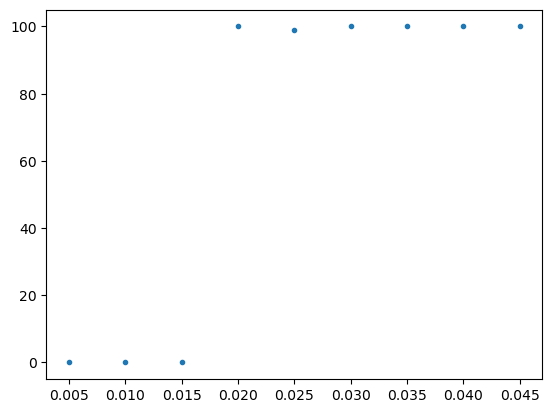

In [5]:
## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
## take only the first data (delete hits from the rising edges)
uni, idx= np.unique(dat0['timestamp'], return_index=True)
dat0 = dat0[idx]
## count hits per event_number
nhit = np.bincount(dat0['event_number'])

# make a plot (injection vs n of hits)
plt.plot(param['inj']/10., nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
#print(dat1)
uni, idx = np.unique(dat1['timestamp'], return_index=True)
dat1 = dat1[idx]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
plt.plot(param['inj']/10, nhit1, '.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

In [21]:
dut.ncols* dut.nrows

1798

## Timewalk 

100 12


(250.0, 375.0)

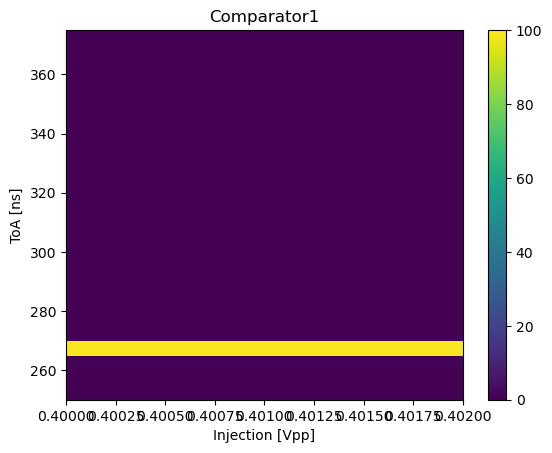

In [12]:
## timewalk
## define the 2D array
n = 100 #2**11
nsteps = param.shape[0]
print(n, nsteps)
toa = np.empty([n, nsteps])
# for each step (event_number)
for i in range(nsteps):
    ## select hit in each event_number
    ev = dat0[dat0['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    ## make a histogram in each evevent
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]
    #print(ev['toa'], toa[:, i])

# plot
plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator1')
plt.colorbar()
plt.xlim(0.4, 0.4+0.0020)
plt.ylim(250, 375)

#### text text text

Text(0.5, 1.0, 'Comparator2')

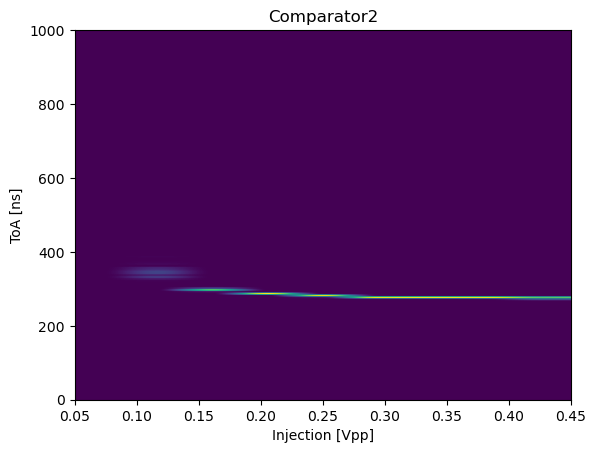

In [18]:
## timewalk
n = 200 #2**11
nsteps = param.shape[0]
toa = np.empty([n, nsteps])
for i in range(nsteps):
    ev = dat1[dat1['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]

plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator2')